<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>


<center><h2>Lab 1 - Series temporales</h2></center>
<br>

*Alumna:* Lucía Benítez

**Práctico:**

1) Levantar los datos desde el archivo dataset/Telefonia_movil.csv. 
Los mismos fueron extraídos de
http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de-suscriptores-de-telefonia-movil-miles-de-minutos/

2) Explorar los datos, visualizarlos

3) Implementar dos modelos (como ser Random Walk (Naïve) y
Exponential Smoothing)

4) Visualizar los resultados y evaluarlos, comparando ambas
implementaciones

Cargamos los paquetes necesarios para realizar análisis de series temporales:

In [354]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm

In [355]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
green='#228B22' 
%matplotlib inline

In [356]:
plt.rcParams['figure.figsize'] = [15, 10]

## Data: Telefonía móvil

Se analizará el *Tráfico de suscriptores de telefonía móvil (miles de minutos)*, los cuales son datos de miles de minutos originados trimestralmente en terminales móviles. 

Los mismos fueron extraídos de
http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de-suscriptores-de-telefonia-movil-miles-de-minutos/

Los cuales tienen tres series temporales: 

    * Minutos pospago salientes (miles)
    * Minutos prepago salientes (miles)
    * Total de minutos salientes (miles)

Como los mismos están registrados por trimestres y por miles, los leeremos por trimestres y dividiremos por 10^6 para una visualización mas cómoda 

In [357]:
data=pd.read_csv('datasets/Telefonia_movil.csv',index_col='Año', parse_dates=True, thousands='.')
data.index=data.index.to_period(freq='Q')+data['Trimestre']-1
data.columns

Index(['Trimestre', 'Minutos pospago salientes (miles)',
       'Minutos prepago salientes (miles)',
       'Total de minutos salientes (miles)', 'Periodo'],
      dtype='object')

In [358]:
data.rename(columns={'Minutos pospago salientes (miles)': 'Pospago (miles)','Minutos prepago salientes (miles)':'Prepago (miles)','Total de minutos salientes (miles)': 'Total (miles)'   }, inplace=True )
data['year'] = data.Periodo.str.slice(-5)
data.head()

,Trimestre,Pospago (miles),Prepago (miles),Total (miles),Periodo,year
2013Q1,1,8785943,6582117,15368060,Ene-Mar 2013,2013
2013Q2,2,9512689,7108640,16621329,Abr-Jun 2013,2013
2013Q3,3,10315484,7335154,17650638,Jul-Sept 2013,2013
2013Q4,4,9809515,6250549,16060064,Oct-Dic 2013,2013
2014Q1,1,10128751,5799223,15927974,Ene-Mar 2013,2013


In [359]:
for columna, tipo in zip(data.columns.values,data.dtypes):
    print("%15s %9s" % (columna,tipo))

      Trimestre     int64
Pospago (miles)     int64
Prepago (miles)     int64
  Total (miles)     int64
        Periodo    object
           year    object


In [360]:
NumFeat = [x for x in data.columns if data[x].dtype == 'int64']
NumFeat.remove("Trimestre")
print(NumFeat)

for feature in NumFeat:
    data[feature] = data[feature]/10**6

['Pospago (miles)', 'Prepago (miles)', 'Total (miles)']


In [361]:
data.tail()

,Trimestre,Pospago (miles),Prepago (miles),Total (miles),Periodo,year
2018Q1,1,13.423580,5.850985,19.274565,Ene-Mar 2018,2018
2018Q2,2,14.240217,6.027374,20.267591,Abr-Jun 2018,2018
2018Q3,3,14.574305,6.108477,20.682782,Jul-Sept 2018,2018
2018Q4,4,14.915060,6.613685,21.528745,Oct-Dic 2018,2018
2019Q1,1,13.937271,6.427084,20.364355,Ene-Mar 2019,2019


In [362]:
y1=data['Pospago (miles)']
y2=data['Prepago (miles)']
y3=data['Total (miles)']

## Análisis de datos exploratorio

Plot de las series temporales:

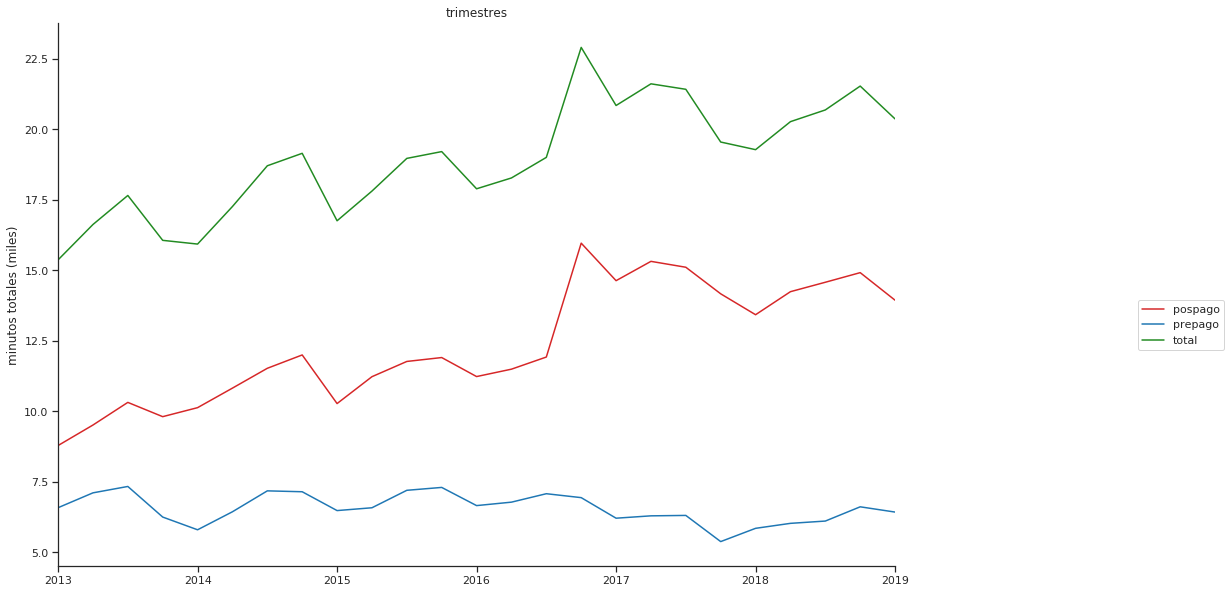

In [363]:
fig, ax= plt.subplots();#figsize=(9,6))
y1.plot(color=red)
y2.plot(color=blue)
y3.plot(color=green)
ax.set_xlabel('')
ax.set_ylabel('minutos totales (miles)')
ax.set_title('trimestres')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot


plt.legend(['pospago','prepago', 'total'],loc='best', bbox_to_anchor=(0.9, 0., 0.5, 0.5))
sns.despine()
plt.show()

Se puede ver que las series 'pospago' y 'total' tienen un comportamiento muy similar mientras que 'prepago' se mantiene aproximadamente constante, por lo que el mayor aporte a los minutos salientes totales serán de las líneas pospagos. 

In [364]:
data.describe().round(2)

,Trimestre,Pospago (miles),Prepago (miles),Total (miles)
count,25.00,25.00,25.00,25.00
mean,2.44,12.36,6.56,18.92
std,1.16,2.09,0.52,1.98
min,1.00,8.79,5.38,15.37
25%,1.00,10.82,6.25,17.65
50%,2.00,11.91,6.58,19.00
75%,3.00,14.24,7.08,20.36
max,4.00,15.96,7.34,22.90


Vemos que tenemos 25 trimestres para cada series. Vemos que la suma de las medias de los minutos de los prepagos y postpagos se corresponden con la media de la total de minutos salientes, siendo el mayor aporte de las líneas pospago.

In [365]:
data['2016Q1':'2017Q4']

,Trimestre,Pospago (miles),Prepago (miles),Total (miles),Periodo,year
2016Q1,1,11.230991,6.656647,17.887638,Ene-Mar 2016,2016
2016Q2,2,11.493027,6.778732,18.271759,Abr-Jun 2016,2016
2016Q3,3,11.923391,7.077838,19.001229,Jul-Sept 2016,2016
2016Q4,4,15.960765,6.938892,22.899656,Oct-Dic 2016,2016
2017Q1,1,14.630269,6.209983,20.840252,Ene-Mar 2017,2017
2017Q2,2,15.315167,6.293563,21.608730,Abr-Jun 2017,2017
2017Q3,3,15.106275,6.308373,21.414647,Jul-Sept 2017,2017
2017Q4,4,14.164552,5.380710,19.545262,Oct-Dic 2017,2017


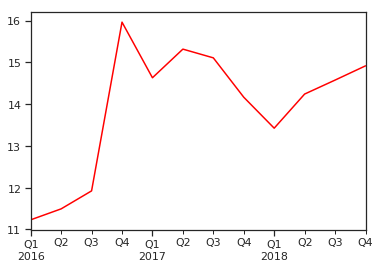

In [366]:
data['2016':'2018']['Pospago (miles)'].plot(color='red',figsize=(6,4));
#data['2016']['Prepago'].plot(color='blue',figsize=(6,4));
#data['2016']['Total'].plot(color='green',figsize=(6,4));


Además, si bien la tendencia es creciente, pareciera haber un salto a finales del año 2016 y durante todo el 2017 para luego normalizarse el consumo, lo que indicaría algún suceso social que no logro identificar (podría tener numerosas causas).

 Para comparar períodos gráficamente:

In [367]:
data['año'] = data.index.year

    Líneas prepagas:

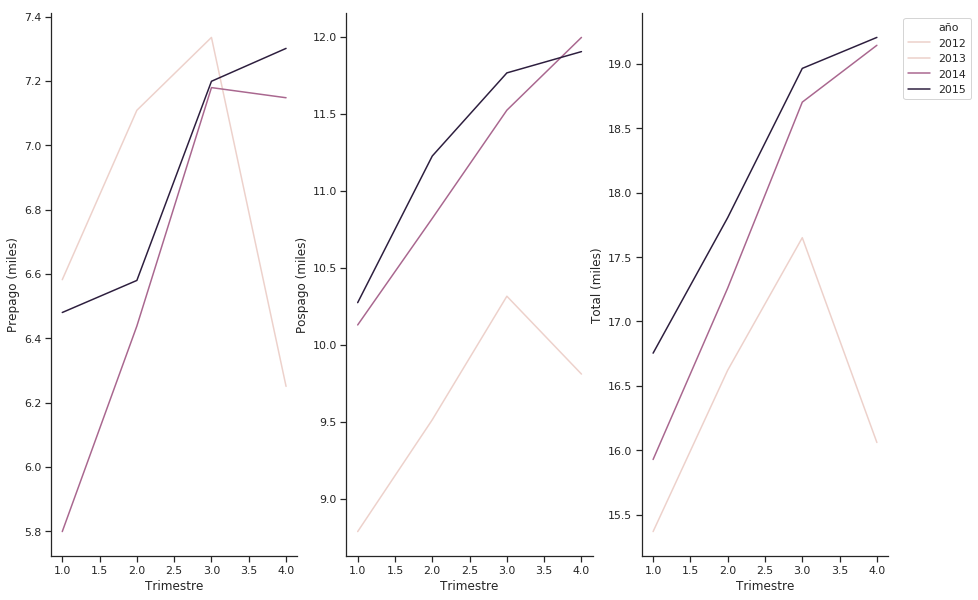

In [368]:
plt.figure(figsize=(15,10))
plt.subplot(1, 3,1)
sns.lineplot('Trimestre','Prepago (miles)',hue='año',data=data['2013':'2015'], markers='None', legend= False);

plt.subplot(1, 3,2)
sns.lineplot('Trimestre','Pospago (miles)',hue='año',data=data['2013':'2015'], markers='None', legend= False);

plt.subplot(1, 3,3)
sns.lineplot('Trimestre','Total (miles)',hue='año',data=data['2013':'2015'], markers='None');

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
sns.despine()


Se puede ver para las líneas prepagas, en los primeros trimestres van en aumento las llamadas mientras que en el último, suele haber un descenso, siendo mucho mas brusco en los años 2013 y 2017, con una subida excepcional en 2018. Hay algún problema en la leyenda, no hay datos para el año 2012. 

En las líneas pospago hay un crecimiento muy lento excepto por el descenso brusco en 2013 y un aumento en el 2016. En los años 2017 también se observa el un decrecimiento en el último trimestre, con un aumento en el último trimestre del 2018 como en las líneas prepagas pero no de forma tan abrupta.

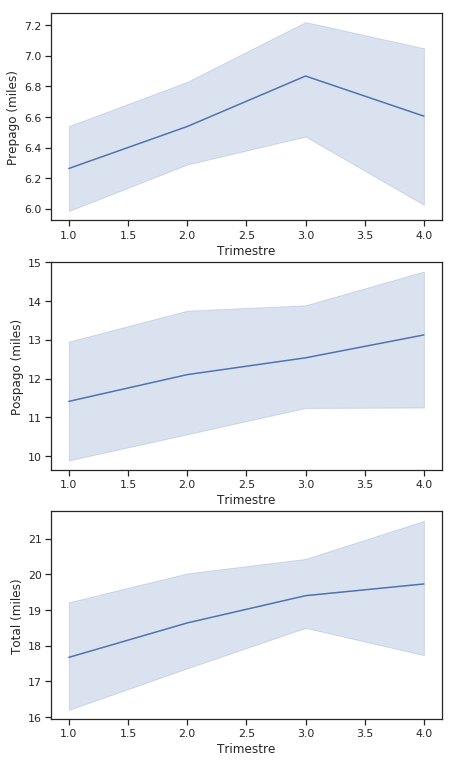

In [369]:
plt.figure(figsize=(7,13))

plt.subplot(3, 1,1)
sns.lineplot('Trimestre','Prepago (miles)', data=data['2013':'2018'],markers='None');

plt.subplot(3, 1, 2)
sns.lineplot('Trimestre','Pospago (miles)', data=data['2013':'2018'],markers='None');

plt.subplot(3, 1,3)
sns.lineplot('Trimestre','Total (miles)', data=data['2013':'2018'],markers='None');


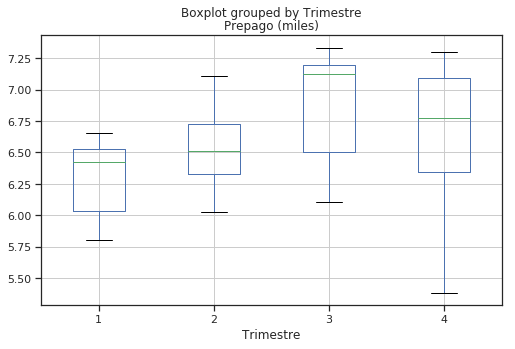

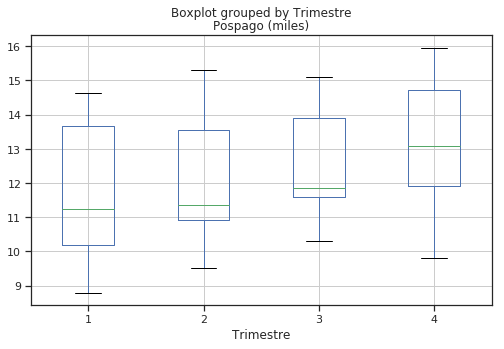

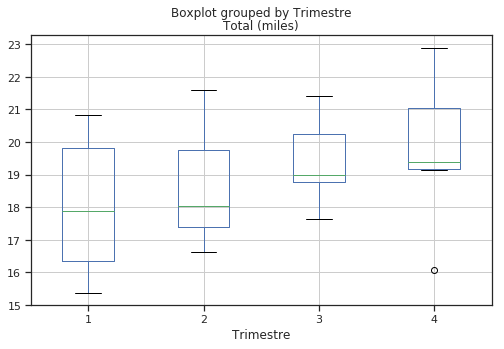

In [370]:
data.boxplot(column='Prepago (miles)',by='Trimestre', figsize=(8,5));
data.boxplot(column='Pospago (miles)',by='Trimestre', figsize=(8,5));
data.boxplot(column='Total (miles)',by='Trimestre', figsize=(8,5));


## Random walk

Intentaremos predecir point forecasts de uno a cuatro trimestres luego del fin de las series. Tomaremos sólo la serie de datos "Total" para mayor claridad


2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [372]:
y1=data['Pospago (miles)']
y2=data['Prepago (miles)']
y3=data['Total (miles)']
y=y3

1) Especificamos el forecast horizon.


In [324]:
#*Pospago:
#h = 4
#test1=pd.period_range(start=y1.index[-1]+1, periods=h, freq='Q')
#pred1=pd.Series(np.repeat(y1.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
#pred1

In [325]:
#*Prepago
#h = 4
#test2=pd.period_range(start=y2.index[-1]+1, periods=h, freq='Q')
#pred2=pd.Series(np.repeat(y2.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
#pred2


In [445]:
# * Total:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
#pred

pred = pd.concat([pred], axis=1)
#pred = pd.concat([pred1,pred2], axis=1)
pred.columns=['Pred-Total']
pred.head()

,Pred-Total
2019Q2,20.364355
2019Q3,20.364355
2019Q4,20.364355
2020Q1,20.364355


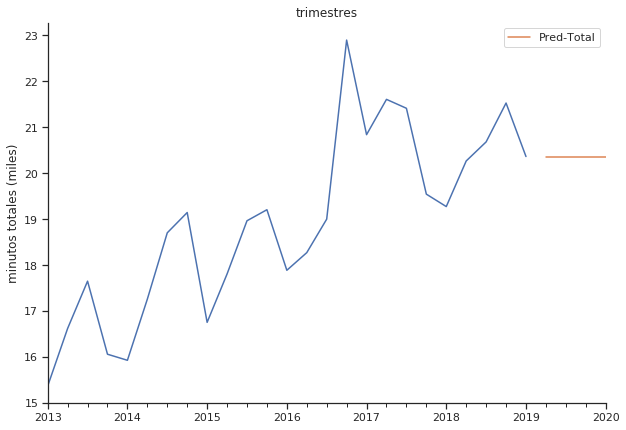

In [451]:
plt.figure(figsize=(10,7))
ax = y.plot()
pred.plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('minutos totales (miles)')
ax.set_title('trimestres')
sns.despine()


Antes de calcular los invervalos forecasts, se estima la desviación estándar de los errores: 

In [374]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1.41

Entonces, se predice un consumo de 20.364355 10^6 minutos salientes, con una desviación sigma=1.41.

Itervalos:

In [378]:
#Using the formulas from the lecture, the interval forecasts are as below:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2019Q2,17.602,23.127
2019Q3,16.457,24.271
2019Q4,15.579,25.150
2020Q1,14.839,25.890


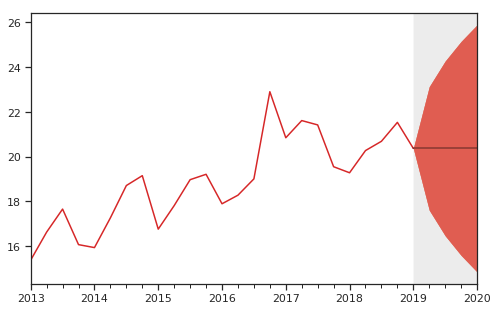

In [379]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['2013':],point_pred,intv,intv,intv)

plt.show()

## Simple exponential smoothing

Vamos a aplicar el método simple exponential smoothing a nuestra serie temporal, de los minutos totales

In [385]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,43.434
Optimized:,True,AIC,17.809
Trend:,None,BIC,20.247
Seasonal:,None,AICC,19.809
Seasonal Periods:,None,Date:,"Sun, 06 Oct 2019"
Box-Cox:,False,Time:,15:14:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5438125,alpha,True
initial_level,16.035260,l.0,True


Also AIC and BIC looks off so we are continue our analysis with MSE.

In [386]:
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit:
 MSE               1.737


You can calculate AIC and BIC as follows

In [387]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -42.378
 AIC               90.756
 BIC               94.413


Veremos cuánto se ajustan los datos suavizados con los datos originales: 

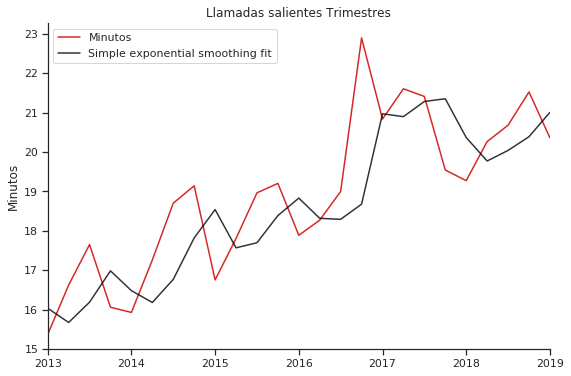

In [384]:
fig, ax= plt.subplots(figsize=(9,6));
y.plot(color=red, label='Minutos')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('Llamadas salientes Trimestres')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics
Realizando diagnóstico residual para la exponential smoothing. Se deben realizar los siguientes diagnósticos: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.


Graficamos el histograma y su kernel density estimation para los residuos, vemos que no tienen distribución gaussiana:

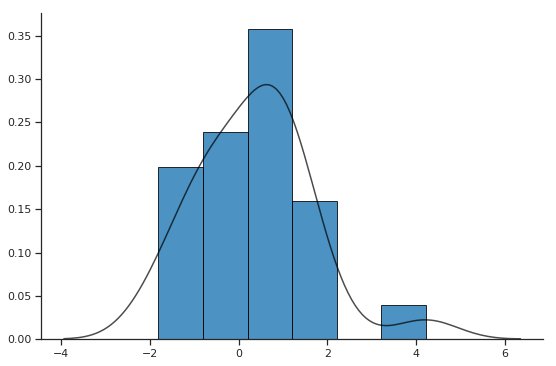

In [415]:
#1. Residual plot.
def hist(series):
    fig, ax= plt.subplots(figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()


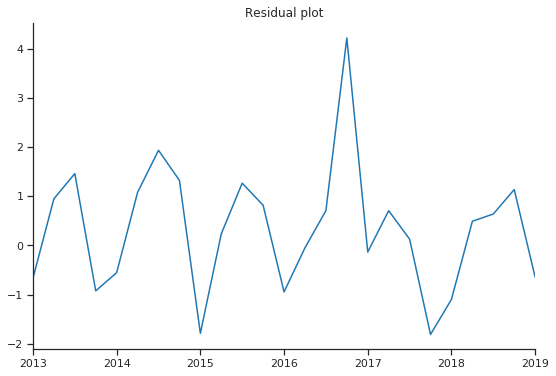

In [416]:
fig, ax= plt.subplots(figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

El plot de los residuos debería ser mas aleatorios y similar al ruido. Es posible que no estemos obteniendo una buena predicción.

Aún así, el residual ACF plot aka correlogram no tiene grandes autocorrelaciones:

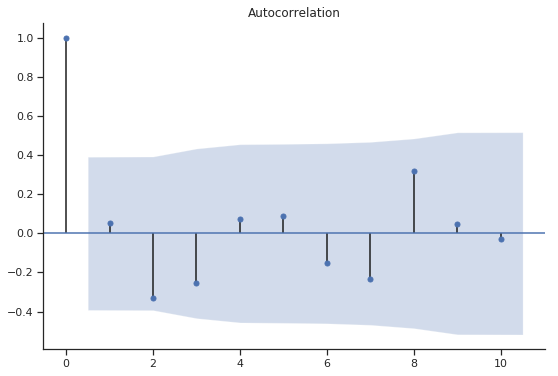

In [417]:
fig, ax = plt.subplots(figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax)
sns.despine()
plt.show()

Los residuos no están correlacionados pero tampoco tienen distribución gaussiana.

## Model validation
Implementamos real time forecasting exercise para comparar los métodos random walk y simple exponential smoothing

In [425]:
# Real time forecasting - use it as a template - expanding window

validation=y['2016Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2016Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
2018Q1,19.545262,20.379837,19.274565
2018Q2,19.274565,19.677908,20.267591
2018Q3,20.267591,20.038137,20.682782
2018Q4,20.682782,20.396708,21.528745
2019Q1,21.528745,21.062302,20.364355


Es esperable que simple exponential smoothing genere mas precisos forecasts que el método de random walk

In [426]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,1.501,0.432
SES,1.562,0.449


## Forecast


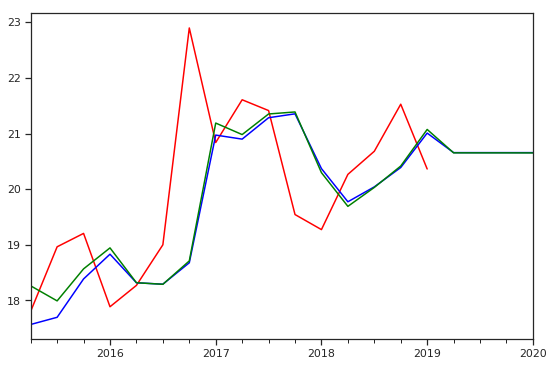

In [453]:
h=4
w=h*4
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red',figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');

La serie predicha consigue capturar características de la serie original y permite estimar un cantidad de minutos que serán consumidos antes del 2020.